# Using numerical and categorical variables together
> We will show how to combine preprocessing steps on numerical and categorical
- toc: true
- badges: false
- comments: true
- author: Cécile Gallioz
- categories: [sklearn]

# Preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

In [2]:
myDataFrame = pd.read_csv("../../scikit-learn-mooc/datasets/adult-census.csv")

In [3]:
myDataFrame = myDataFrame.drop(columns="education-num")

In [4]:
target_column = 'class'
target = myDataFrame[target_column]

In [5]:
pie = target.value_counts(normalize=True)
pie

 <=50K    0.760718
 >50K     0.239282
Name: class, dtype: float64

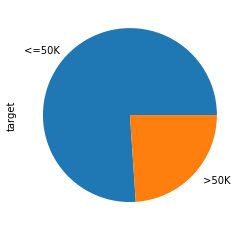

In [6]:
pie.plot(kind="pie", label="target");

In [7]:
data = myDataFrame.drop(columns=target_column)

In [8]:
print(f"The dataset data contains {data.shape[0]} samples and {data.shape[1]} features")

The dataset data contains 48842 samples and 12 features


In [9]:
data.dtypes

age                int64
workclass         object
education         object
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
dtype: object

In [10]:
numerical_columns = selector(dtype_exclude=object)(data)

In [11]:
categorical_columns = selector(dtype_include=object)(data)

In [12]:
all_columns = numerical_columns + categorical_columns
data = data[all_columns]

In [13]:
print(f"The dataset data contains {data.shape[0]} samples and {data.shape[1]} features")

The dataset data contains 48842 samples and 12 features


In [14]:
data_numerical = data[numerical_columns]
data_categorical = data[categorical_columns]

# Numerical
## Normalization + Regression

In [15]:
model = make_pipeline(
    StandardScaler(), 
    LogisticRegression())

In [16]:
cv_results = cross_validate(model, data_numerical, target, cv=10)

In [17]:
scores = cv_results["test_score"]
fit_time = cv_results["fit_time"]
print("The accuracy is "
      f"{scores.mean():.3f} +/- {scores.std():.3f}, for {fit_time.mean():.3f} seconds")

The accuracy is 0.800 +/- 0.004, for 0.077 seconds


# Categorical
## Hot encoding + Regression = good

In [18]:
model = make_pipeline(
    OneHotEncoder(handle_unknown="ignore"), 
    LogisticRegression(max_iter=500)
)

In [19]:
cv_results = cross_validate(model, data_categorical, target, cv=10)

In [20]:
scores = cv_results["test_score"]
fit_time = cv_results["fit_time"]
print("The accuracy is "
      f"{scores.mean():.3f} +/- {scores.std():.3f}, for {fit_time.mean():.3f} seconds")

The accuracy is 0.833 +/- 0.003, for 0.706 seconds


## Ordinal encoding + Regression = not good

In [21]:
model = make_pipeline(
    OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), 
    LogisticRegression(max_iter=500)
)

In [22]:
cv_results = cross_validate(model, data_categorical, target, cv=10)

In [23]:
scores = cv_results["test_score"]
fit_time = cv_results["fit_time"]
print("The accuracy is "
      f"{scores.mean():.3f} +/- {scores.std():.3f}, for {fit_time.mean():.3f} seconds")

The accuracy is 0.755 +/- 0.002, for 0.354 seconds


# Numerical & Categorical
## Normalize + Hot encoding + Linear Regression = good
Linear models are nice because they are usually cheap to train, small to deploy, fast to predict and give a good baseline.

In [24]:
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()

In [25]:
preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, categorical_columns),
    ('standard-scaler', numerical_preprocessor, numerical_columns)])

In [26]:
model = make_pipeline(
    preprocessor, 
    LogisticRegression(max_iter=1500))

In [27]:
cv_results = cross_validate(model, data, target, cv=10)

In [28]:
scores = cv_results["test_score"]
fit_time = cv_results["fit_time"]
print("The accuracy is "
      f"{scores.mean():.3f} +/- {scores.std():.3f}, for {fit_time.mean():.3f} seconds")

The accuracy is 0.851 +/- 0.003, for 1.062 seconds


## Ordinal encoding + Gradient-boosting trees = best
For tree-based models, the handling of numerical and categorical variables is
simpler than for linear models:
* we do not need to scale the numerical features
* using an ordinal encoding for the categorical variables is fine even if
  the encoding results in an arbitrary ordering


In [29]:
categorical_preprocessor_tree = OrdinalEncoder(
                                            handle_unknown="use_encoded_value",
                                            unknown_value=-1)

In [30]:
preprocessor_tree = ColumnTransformer([
    ('categorical', categorical_preprocessor_tree, categorical_columns)], remainder="passthrough")

In [31]:
model = make_pipeline(
    preprocessor_tree, 
    HistGradientBoostingClassifier())

In [32]:
cv_results = cross_validate(model, data, target, cv=10, return_estimator=True)

In [33]:
scores = cv_results["test_score"]
fit_time = cv_results["fit_time"]
print("The accuracy is "
      f"{scores.mean():.3f} +/- {scores.std():.3f}, for {fit_time.mean():.3f} seconds")

The accuracy is 0.874 +/- 0.003, for 1.791 seconds
